 # SAR Target/Object Classification Using Transfert Learning


Mounting Google Drive for Cloud based Processing using GPUs

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import librairies

In [2]:
import sys, os
import collections
import io
import math
import time
import random
from six.moves import urllib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import scipy.misc as im
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from skimage.transform import resize
import sklearn.metrics as sk_metrics
from skimage import data
from IPython.display import clear_output, Image, display, HTML

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, Dense, BatchNormalization, Dropout, MaxPool2D, Flatten
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from keras.optimizers import Adam, RMSprop

In [4]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#import tensorflow_hub as hubM

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


## Split data on train test and Explore the images

In [6]:
main_path_data = "/content/gdrive/My Drive/Colab Notebooks/"

In [7]:
MSTAR_DIR = main_path_data + 'MSTAR-10/'
os.listdir(MSTAR_DIR)

['train', 'test']

In [8]:
def make_train_and_test_sets(input_data_dir):
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.gfile.Walk(input_data_dir):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes


In [9]:
RANDOM_SEED = 42
TRAIN_FRACTION = 0.8
MSTAR_TRAIN_DIR  = MSTAR_DIR + 'train'
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets(input_data_dir = MSTAR_TRAIN_DIR)
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))


The dataset has 10 label classes: odict_values(['2S1', 'BMP2', 'BRDM_2', 'BTR60', 'BTR70', 'D7', 'T62', 'T72', 'ZIL131', 'ZSU_23_4'])
There are 2193 training images
there are 553 test images


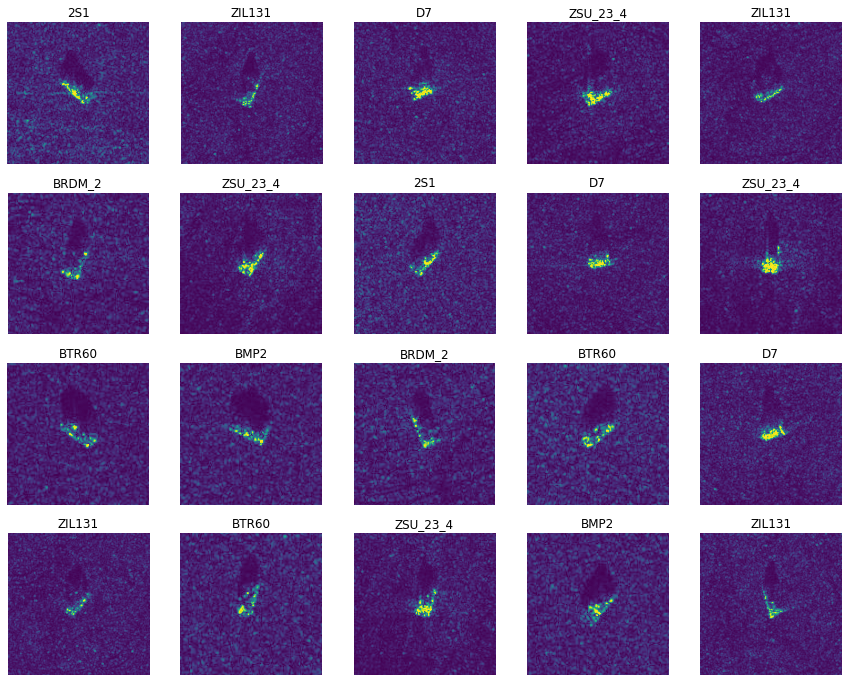

In [10]:
#@title Show some labeled images
def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, flower_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(flower_class)

NUM_IMAGES = 20 #@param {type: 'integer'}
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

In [11]:
def get_nb_img_color_channel(input_img_path):
  from PIL import Image
  # open image using PIL
  img = Image.open(input_img_path)
  # convert to numpy array
  img = np.array(img)
  # find number of channels
  if img.ndim == 2:
      channels = 1
      print("image has 1 channel")
  else:
      channels = image.shape[-1]
      print("image has", channels, "channels")
  return channels

In [12]:
get_nb_img_color_channel(TRAIN_EXAMPLES[0][0])

image has 1 channel


1

# II-Train Using Transfert Learning
Inspired from https://github.com/Accioy/sar-10-classification/blob/master/nn.py

# II-1-data preparation and augmentation

In [13]:
def get_nb_images_of_train_val(input_folder):
  count = 0
  for i in os.listdir(input_folder):
    for j in i:
      nb_img = len(os.listdir(input_folder + '/' + i))
    count += nb_img
  return count

def compute_nb_paramters_per_layer(kernel_size, stride, nb_filter):
  return (kernel_size[0]*kernel_size[1]*stride+1)*nb_filter

In [26]:
input_image_size = [299,299]
batch_size = 64
#color_mode = 'grayscale'
class_mode = 'categorical'

In [27]:
directory_train = os.path.join(main_path_data,'MSTAR-10','train')
directory_val = os.path.join(main_path_data,'MSTAR-10','test')

In [28]:
# add data augmentation only for the training set 
train_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.1,
      fill_mode='constant',
      cval=0.0,
      horizontal_flip=True,
      vertical_flip=True,
      rescale=1./255
  )
print('Creation of train genarator include data augmentation ')

val_generator = ImageDataGenerator(rescale=1./255)
print('Creation of val genarator without data augmentation (only rescale the image to normalize them) ')

Creation of train genarator include data augmentation 
Creation of val genarator without data augmentation (only rescale the image to normalize them) 


In [29]:
# preparation of data train and data val before feed them to the netwrok architecture model
print('data_training'.upper())
data_training = train_generator.flow_from_directory(directory=directory_train,
                                                 target_size=input_image_size,
                                                 class_mode=class_mode ,
                                                 batch_size=batch_size,
                                                 shuffle=True)

print('data_validation'.upper())
data_validation = val_generator.flow_from_directory(directory=directory_val,
                                                   target_size=input_image_size,
                                                   class_mode=class_mode,
                                                   batch_size=batch_size,
                                                   shuffle=True)

# check the number of shape include the nb color channel on the generated train and validation images
x_train, y_train = next(data_training)
print(f'Train generator output shapes: {x_train.shape}, {y_train.shape}')
x_val, y_val = next(data_validation)
print(f'Val generator output shapes: {x_val.shape}, {y_val.shape}')

DATA_TRAINING
Found 2746 images belonging to 10 classes.
DATA_VALIDATION
Found 2425 images belonging to 10 classes.
Train generator output shapes: (64, 299, 299, 3), (64, 10)
Val generator output shapes: (64, 299, 299, 3), (64, 10)


In [30]:
# print index and name of training classes 
data_training.class_indices

{'2S1': 0,
 'BMP2': 1,
 'BRDM_2': 2,
 'BTR60': 3,
 'BTR70': 4,
 'D7': 5,
 'T62': 6,
 'T72': 7,
 'ZIL131': 8,
 'ZSU_23_4': 9}

In [31]:
# print index and name of validation classes 
data_validation.class_indices

{'2S1': 0,
 'BMP2': 1,
 'BRDM_2': 2,
 'BTR60': 3,
 'BTR70': 4,
 'D7': 5,
 'T62': 6,
 'T72': 7,
 'ZIL131': 8,
 'ZSU_23_4': 9}

**Get the train and val size and Define the number of step per epoch**

In [32]:
train_size = get_nb_images_of_train_val(directory_train)
val_size = get_nb_images_of_train_val(directory_val)
print(f'Nb TRAIN images = {train_size} \nNb VAL images = {val_size}')
step_train_per_epoch = train_size//batch_size
step_val_per_epoch = val_size//batch_size
print(f'Nb Train steps per epoch = {step_train_per_epoch}\nNb Val steps per epoch = {step_val_per_epoch}')

Nb TRAIN images = 2746 
Nb VAL images = 2425
Nb Train steps per epoch = 42
Nb Val steps per epoch = 37


# II-2-Build architecture by transfert learning from exiting architecture 

**A-Fine tunning using inception v3**

tf.keras.applications.InceptionV3(
                                  include_top=True,
                                  weights="imagenet",
                                  input_tensor=None,
                                  input_shape=None,
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation="softmax",
                              )


In [43]:
input_shape_image = (input_image_size[0],input_image_size[1],3)
inception_model = keras.applications.inception_v3.InceptionV3(include_top=False, input_shape=input_shape_image, weights='imagenet')

In [44]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

remove the 2 last layer of inception model and create new Dense layers related to MSTAR model 
input = inception_model.layers[-2].output
mstar_class_layer = Dense(NUM_CLASSES, activation='softmax',kernel_initializer='he_normal')(input) 
model = Model(inception_model.input, mstar_class_layer)
model.summary()

In [46]:
# Create new Dense layers related to MSTAR model 
x=inception_model.output
x=Dense(2048,activation = 'relu')(x)
#x=Dropout(0.5)(x)
#x=Dense(4096,activation = 'relu')(x)
#x=Dropout(0.5)(x)
mstar_class_layer = Dense(NUM_CLASSES, activation='softmax')(x) 
custom_model = Model(inception_model.input, mstar_class_layer)
custom_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [48]:
def show_trainble_layers(model_name):
  for i, layer in enumerate(model_name.layers):
    print(i,layer.name,layer.trainable)

**Freeze layers**

In [51]:
#Freeze few layers : if you want todo some experiments
#layers[:-4] mean that you keep only the last 4 layers and you freeze all previous layers 
for layer in custom_model.layers[:-4]:
    layer.trainable = False
show_trainble_layers(model_name=custom_model)

0 input_3 False
1 conv2d_188 False
2 batch_normalization_188 False
3 activation_188 False
4 conv2d_189 False
5 batch_normalization_189 False
6 activation_189 False
7 conv2d_190 False
8 batch_normalization_190 False
9 activation_190 False
10 max_pooling2d_8 False
11 conv2d_191 False
12 batch_normalization_191 False
13 activation_191 False
14 conv2d_192 False
15 batch_normalization_192 False
16 activation_192 False
17 max_pooling2d_9 False
18 conv2d_196 False
19 batch_normalization_196 False
20 activation_196 False
21 conv2d_194 False
22 conv2d_197 False
23 batch_normalization_194 False
24 batch_normalization_197 False
25 activation_194 False
26 activation_197 False
27 average_pooling2d_18 False
28 conv2d_193 False
29 conv2d_195 False
30 conv2d_198 False
31 conv2d_199 False
32 batch_normalization_193 False
33 batch_normalization_195 False
34 batch_normalization_198 False
35 batch_normalization_199 False
36 activation_193 False
37 activation_195 False
38 activation_198 False
39 activation

# II-3-Launch training: 

*   Define the hyperparameters of training : lr, optimizer

1.   compile the model
2.   fit the model

In [52]:
import datetime
date_object = datetime.date.today()
date_object = str(date_object).replace('-','_')

In [53]:
lr = 1e-3
decacy = 0
nb_epochs = 20

In [54]:
path_to_save_model = main_path_data + f'trained_models/{date_object}'
model_path = path_to_save_model  + f'/mstar_model_{date_object}_' + '{epoch:02d}-{val_acc:.2f}.hdf5'
model_path

'/content/gdrive/My Drive/Colab Notebooks/trained_models/2021_04_18/mstar_model_2021_04_18_{epoch:02d}-{val_acc:.2f}.hdf5'

In [56]:
# model callbeck list and save option 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001,verbose=1)

# keep the best checkpoint
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=2, mode='auto',save_best_only=True) 

# stop training when the accuracy does not continue improvement
early_stopping_monitor = EarlyStopping(monitor='val_acc',min_delta=0,patience=5,verbose=0, mode='auto')

callbacks_list = [checkpoint, reduce_lr]

In [57]:
# define the optimizer
adam = Adam(lr=lr, decay=decacy) 
rmsprop = RMSprop(lr=lr, decay=decacy)

In [58]:
# compile the model
#model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['categorical_accuracy'])
custom_model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])


In [ ]:
# Launch training 
history = custom_model.fit_generator(generator=data_training,
                    validation_data=data_validation,
                    use_multiprocessing=False,
                    workers=4,
                    steps_per_epoch=step_train_per_epoch,
                    epochs=nb_epochs,
                    validation_steps=step_val_per_epoch,
                    verbose=1,
                    callbacks=callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1240: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/20


In [ ]:
history.history.keys()

In [ ]:
print('max acc',np.max(history.history['acc']))
print('max val_acc',np.max(history.history['val_acc']))

print('max loss',np.max(history.history['loss']))
print('max val_loss',np.max(history.history['val_loss']))


model.fit_generator(generator=data_train,epochs=100,
    validation_data=data_validation)
model.save('mstar10.h5')

# **III-Aanlysis of model performances**

**Plot historay training**

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epoch', fontsize=16)
plt.legend(['acc: train', 'acc: val'], loc='upper left', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Make prediction of all validation set**

In [ ]:
selected_model_name = 'mstar_model_2021_04_05_01-0.63.hdf5'
path_selected_model = f'{path_to_save_model}/{selected_model_name}' 
print(f'Prediction using inference model: {path_selected_model}')

In [ ]:
inference_model = load_model(path_selected_model)

In [ ]:
inference_model.layers[0].input_shape

In [ ]:
# generate the test set images
test_generator = ImageDataGenerator(rescale=1./255)
data_test = test_generator.flow_from_directory(directory=directory_val,
    target_size=[128,128],color_mode='grayscale',class_mode='categorical',
    batch_size=32,shuffle=False)
print(data_test.class_indices)

In [ ]:
evaluation = inference_model.evaluate_generator(data_test)


In [ ]:
print(evaluation)

In [ ]:
os.listdir(directory_val)

In [ ]:
picturePath = directory_val + '/'+ 'BTR60' + '/'
os.listdir(picturePath)[0]
picturePath = picturePath + os.listdir(picturePath)[20]
picturePath

In [ ]:
img_width = 128
img_height = 128

In [ ]:
index_class_val_set = data_validation.class_indices
index_class_val_set

In [ ]:
image_path = picturePath
img = image.load_img(image_path, target_size=(img_width, img_height), color_mode="grayscale")
plt.imshow(img, cmap='gray')
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
result = inference_model.predict(img)
plt.title(result)
plt.show()

**Plot Confusion matrix**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#Confution Matrix and Classification Report
Y_pred = inference_model.predict_generator(data_test)

In [ ]:
len(Y_pred)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(data_test.classes, y_pred)
print(cm)

In [ ]:
target_names = list(index_class_val_set.keys())


In [ ]:

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# plot the confusion matrix
plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
make_confusion_matrix(cm,
                          group_names=None,
                          categories=target_names,
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=(12,10),
                          cmap='Blues',
                          title=None)

In [ ]:
print('Classification Report')
print(classification_report(data_validation.classes, y_pred, target_names=target_names))